In [1]:
import psycopg2
import datetime
import json
from dateutil.parser import parse
from dateutil.tz import gettz
import os
import pandas as pd
import numpy

In [50]:
conn = psycopg2.connect("dbname= chicago_taxi user= wenzhe host=localhost password=123")
cur = conn.cursor()

### CREATE TABLE

In [51]:
cur.execute("DROP TABLE chicago_2015")

In [52]:
# columns: trip_id month date hr trip_seconds trip_miles fare trip_total company
cur.execute("CREATE TABLE chicago_2015(trip_miles float8, fare float8, company text, year int, month int, date text, hr int)")

In [167]:
# header = ['Trip ID', 'Taxi ID', 'Trip Start Timestamp', 'Trip End Timestamp', 'Trip Seconds', 'Trip Miles', 'Pickup Census Tract', \
#  'Dropoff Census Tract', 'Pickup Community Area', 'Dropoff Community Area', 'Fare', 'Tips', 'Tolls', 'Extras', 'Trip Total',\
#  'Payment Type', 'Company', 'Pickup Centroid Latitude', 'Pickup Centroid Longitude', 'Pickup Centroid Location', \
#  'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude', 'Dropoff Centroid  Location', 'year', 'month', 'date\n']
result = pd.DataFrame()
for file in os.listdir('G:/data_incubator/data/'):
    if file.startswith('chicago_taxi_2013'):
        print os.path.splitext(file)[0]
        df = pd.read_csv(file)
#         df = df.loc[df.month == 1]
#         result = result.append(df[['year','month','date','hr','Trip Miles','Fare','Company']])

chicago_taxi_201701


In [168]:
print result.head()
result.to_csv('database_chicago_taxi_201701.csv',index=False)
# print 'total trips in 2016: ' + str(len(result))
# path = os.path.abspath( 'database_' + os.path.splitext(file)[0] + '.csv')
# print path    

,Trip ID,month,date,hr,Trip Seconds,Trip Miles,Fare,Trip Total,Company
82,39b953b5259b6377f29f0b48dda5a80d8959e349,1,01/31,23,180.0,0.6,5.00,5.0,Taxi Affiliation Services
83,9dcc6a0cfa1f5430a34b8c8133ffb91d0f0ae8d8,1,01/31,23,960.0,0.5,22.00,26.4,Taxi Affiliation Services
84,1930cbca56bee20f60d541307cfb89318a5b4da1,1,01/31,23,180.0,0.6,5.00,8.0,KOAM Taxi Association
85,9d48a32f0fd1af2f17710771b9fe41f7eb788b71,1,01/31,23,1080.0,10.8,28.25,33.9,Taxi Affiliation Services
86,1c6b92efcbaa815a0e880ffe9401bc99c78ccefd,1,01/31,23,60.0,0.4,4.00,6.5,None


In [53]:
cur.execute("COPY chicago_2015 FROM 'G:\data_incubator\data\chicago_taxi_2015.csv' DELIMITER ',' CSV HEADER;") 

In [54]:
conn.commit()

In [55]:
cur.close()
conn.close()

### QUERY

#### volumn

In [61]:
QUERY = 'select count(year) from chicago_2015'
conn = psycopg2.connect("dbname= chicago_taxi user= wenzhe host=localhost password=123")
cur = conn.cursor()
cur.execute(QUERY)
rows = cur.fetchall()
rows

[(27400525L,)]

In [178]:
QUERY = 'select count(trip_id) from chicago_2017'
conn = psycopg2.connect("dbname= chicago_taxi user= wenzhe host=localhost password=123")
cur = conn.cursor()
cur.execute(QUERY)
rows = cur.fetchall()
rows

[(1040178L,)]

#### date/month

In [89]:
QUERY = 'select month, sum(fare), count(fare) from chicago_2016 group by month'
conn = psycopg2.connect("dbname= chicago_taxi user= wenzhe host=localhost password=123")
cur = conn.cursor()
cur.execute(QUERY)
rows = cur.fetchall()

fetchdata=pd.DataFrame(rows)
fetchdata.columns = ['month','fare','volumn']
# fetchdata.date = fetchdata.date.apply(lambda x: x+'/2015')
fetchdata['year'] = 2016
fetchdata.to_csv('volumn_2016.csv',index=False)

#### company

In [241]:
QUERY="select date, sum(trip_total), sum(fare),count(trip_id) from chicago_2016 d where company = 'Taxi Affiliation Services' group by date ;"
conn = psycopg2.connect("dbname= chicago_taxi user= wenzhe host=localhost password=123")
cur = conn.cursor()
cur.execute(QUERY)
rows = cur.fetchall()

In [242]:
fetchdata=pd.DataFrame(rows)
print len(fetchdata)
fetchdata.columns = ['date','trip_total','fare','volumn']
fetchdata.to_csv('query.csv',index=False)

366


IOError: [Errno 13] Permission denied: 'query.csv'

In [237]:
QUERY="select trip_id,month,date,hr,trip_seconds,trip_miles, fare, trip_total from chicago_2017 d where company = 'Taxi Affiliation Services';"
conn = psycopg2.connect("dbname= chicago_taxi user= wenzhe host=localhost password=123")
cur = conn.cursor()
cur.execute(QUERY)
rows = cur.fetchall()

In [238]:
fetchdata=pd.DataFrame(rows)
print len(fetchdata)
fetchdata.columns = ['trip_id','month','date','hr','trip_seconds','trip_miles','fare','trip_total']
fetchdata.to_csv('Taxi Affiliation Services_17.csv',index=False)

201988


In [200]:
fare = fetchdata[fetchdata.trip_miles > 0]
fare['fare_mile'] = fare.fare / fare.trip_miles

D:\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [213]:
fare_l = fare[fare.fare_mile >= 10]
fare_m = fare[(fare.fare_mile >= 3) & (fare.fare_mile < 10)]
fare_s = fare[fare.fare_mile < 3]

In [214]:
print len(fare_l)
print len(fare_m)
print len(fare_s)

1164027
1956268
438937


In [226]:
print numpy.median(fare_l.fare_mile)
print numpy.median(fare_m.fare_mile)
print numpy.median(fare_s.fare_mile)

61.6666666667
5.17857142857
2.62


In [221]:
fare_l.groupby('month')['trip_id'].count()

month
1     107075
2     108198
3     116523
4     115223
5     120042
6     118983
7     108681
8      96722
9      84960
10     77577
11     60375
12     49668
Name: trip_id, dtype: int64

In [222]:
fare_m.groupby('hr')['trip_id'].count()

hr
0      71501
1      60945
2      53507
3      43316
4      29462
5      17462
6      11931
7      25424
8      65656
9      98049
10     92490
11     86326
12    102742
13    105171
14    102342
15     99827
16    105953
17    115291
18    128456
19    138079
20    122923
21     96387
22     93137
23     89891
Name: trip_id, dtype: int64

In [223]:
fare_s.groupby('hr')['trip_id'].count()

hr
0     15226
1     12500
2      8591
3      6634
4      6308
5      9787
6     13772
7     15446
8     15666
9     17899
10    22695
11    22144
12    24783
13    24438
14    24276
15    24576
16    24902
17    22228
18    17918
19    20249
20    23313
21    23917
22    22978
23    18691
Name: trip_id, dtype: int64

### regression

In [228]:
from sklearn import linear_model
import random

# sample = fare.sample(frac=0.01, replace=True)
# print len(sample)
X = fare_l.trip_miles.reshape(len(fare_l),1)
y = fare_l.fare.reshape(len(fare_l),1)
lr = linear_model.LinearRegression()
lr.fit(X,y)
pred = lr.predict(X)
print lr.score(X,y)

0.791033323616


D:\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
D:\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [230]:
print lr.coef_

[[ 34.05339318]]


In [87]:
# def outlierCleaner(predictions, x, y):
#     import numpy
#     cleaned_data = []
#     residual = (predictions-y) ** 2
#     for i in range(len(residual)):
#         if residual[i][0] <= numpy.percentile(residual, 90):
#             cleaned_data.append((x[i][0],y[i][0]))
#     return cleaned_data

In [104]:
# cleaned_data = outlierCleaner(pred,X,y)
# new_X,new_y = zip(*cleaned_data) 
# X = numpy.array(new_X).reshape(len(new_X),1)
# y = numpy.array(new_y).reshape(len(new_X),1)
# lr = linear_model.LinearRegression()
# lr.fit(X,y)
# print lr.coef_
# print lr.score(X,y)

[[ 2.0690253]]


### plot

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

#### 1. Taxi Affiliation Services

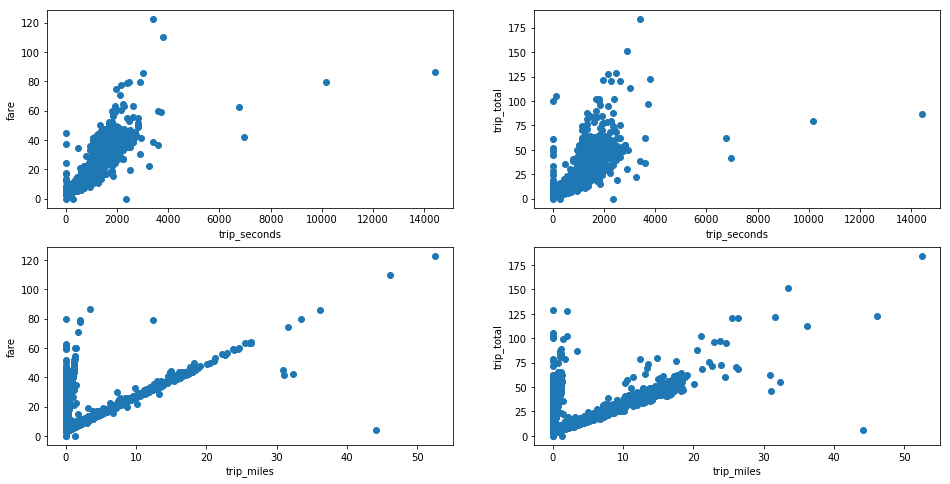

In [196]:
fig = plt.figure(figsize=(16, 8)) 
plt.subplot(2, 2, 1)
plt.scatter(fetchdata[:3000].trip_seconds, fetchdata[:3000].fare)
plt.xlabel('trip_seconds')
plt.ylabel('fare')

plt.subplot(2, 2, 2)
plt.scatter(fetchdata[:3000].trip_seconds, fetchdata[:3000].trip_total)
plt.xlabel('trip_seconds')
plt.ylabel('trip_total')

plt.subplot(2, 2, 3)
plt.scatter(fetchdata[:3000].trip_miles, fetchdata[:3000].fare)
plt.xlabel('trip_miles')
plt.ylabel('fare')

plt.subplot(2, 2, 4)
plt.scatter(fetchdata[:3000].trip_miles, fetchdata[:3000].trip_total)
plt.xlabel('trip_miles')
plt.ylabel('trip_total')

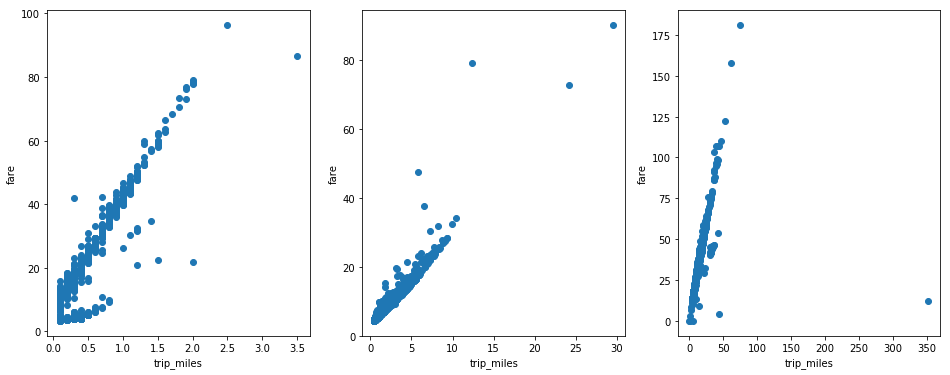

In [215]:
fig = plt.figure(figsize=(16, 6)) 
plt.subplot(1, 3, 1)
plt.scatter(fare_l[:3000].trip_miles, fare_l[:3000].fare)
plt.xlabel('trip_miles')
plt.ylabel('fare')

plt.subplot(1, 3, 2)
plt.scatter(fare_m[:3000].trip_miles, fare_m[:3000].fare)
plt.xlabel('trip_miles')
plt.ylabel('fare')

plt.subplot(1, 3, 3)
plt.scatter(fare_s[:3000].trip_miles, fare_s[:3000].fare)
plt.xlabel('trip_miles')
plt.ylabel('fare')

#### 2. Blue Ribbon Taxi Association Inc.

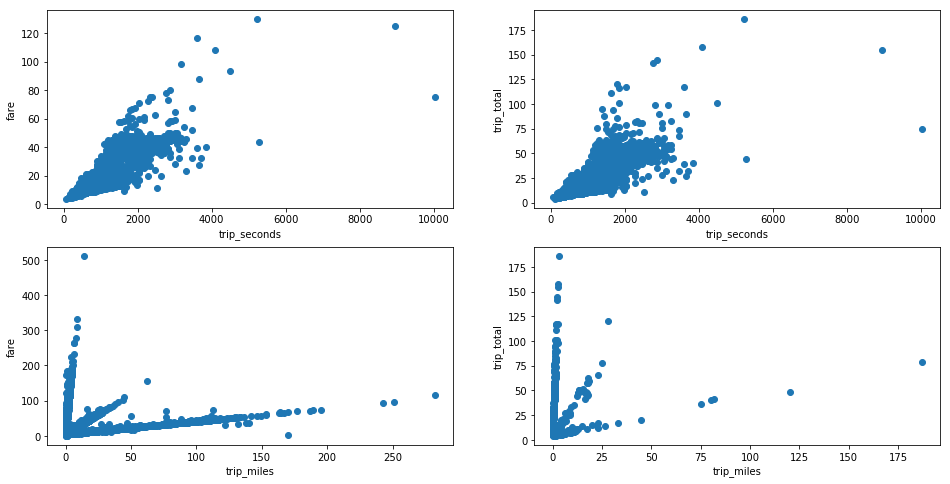

In [109]:
fig = plt.figure(figsize=(16, 8)) 
plt.subplot(2, 2, 1)
plt.scatter(fetchdata[:3000].trip_seconds, fetchdata[:3000].fare)
plt.xlabel('trip_seconds')
plt.ylabel('fare')

plt.subplot(2, 2, 2)
plt.scatter(fetchdata[:3000].trip_seconds, fetchdata[:3000].trip_total)
plt.xlabel('trip_seconds')
plt.ylabel('trip_total')

plt.subplot(2, 2, 3)
plt.scatter(fetchdata.trip_miles, fetchdata.fare)
plt.xlabel('trip_miles')
plt.ylabel('fare')

plt.subplot(2, 2, 4)
plt.scatter(fetchdata[:3000].trip_miles, fetchdata[:3000].trip_total)
plt.xlabel('trip_miles')
plt.ylabel('trip_total')

#### 3.Dispatch Taxi Affiliation

In [113]:
sample = fare.sample(frac=0.01, replace=True)
print len(sample)

35528


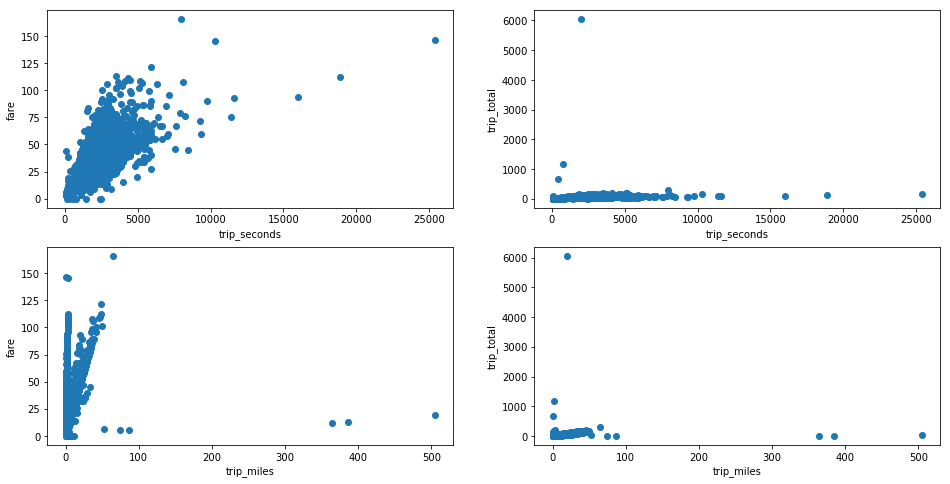

In [114]:
fig = plt.figure(figsize=(16, 8)) 
plt.subplot(2, 2, 1)
plt.scatter(sample.trip_seconds, sample.fare)
plt.xlabel('trip_seconds')
plt.ylabel('fare')

plt.subplot(2, 2, 2)
plt.scatter(sample.trip_seconds, sample.trip_total)
plt.xlabel('trip_seconds')
plt.ylabel('trip_total')

plt.subplot(2, 2, 3)
plt.scatter(sample.trip_miles, sample.fare)
plt.xlabel('trip_miles')
plt.ylabel('fare')

plt.subplot(2, 2, 4)
plt.scatter(sample.trip_miles, sample.trip_total)
plt.xlabel('trip_miles')
plt.ylabel('trip_total')